In [1]:
import numpy as np
import pandas as pd
import os
import openpyxl
import tensorflow as tf
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
from tensorflow.keras.layers import LSTM,Dense,GRU,Dropout,SimpleRNN
from sklearn.metrics import mean_squared_error
# from keras.callbacks import EarlyStopping, ModelCheckpoint
import random as rn

In [2]:
seed_num =5
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
n_hours = 3
n_features = 43
train_num_24 = 2789
train_num_25 = 2892
train_num_19 = 1934

In [5]:
from os.path import join
df = pd.read_excel('rain_data.xlsx')
df.head()

,홍수사상번호,연,월,일,시간,유입량,데이터집단 1,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 38,Unnamed: 39,Unnamed: 40,데이터 집단 6,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47
0,1,2006,7,10,8,189.100000,6.4,7,7,7,...,8,2.54,122.660,6.4,7,7,8,8,2.54,122.610
1,1,2006,7,10,9,216.951962,6.3,7,8,7,...,10,2.53,122.648,7.3,7,8,10,10,2.53,122.600
2,1,2006,7,10,10,251.424419,6.4,7,9,7,...,11,2.53,122.636,8.2,7,9,10,11,2.53,122.590
3,1,2006,7,10,11,302.812199,7.3,7,10,7,...,14,2.53,122.620,11.3,9,10,15,14,2.53,122.585
4,1,2006,7,10,12,384.783406,8.2,7,12,8,...,16,2.53,122.604,14.4,12,12,18,16,2.53,122.575


In [6]:
# df_metrix 만드는 과정
df_matrix = df.to_numpy()
df_matrix = df_matrix[0:train_num_25, 5:]
print(df_matrix)

df_matrix = df_matrix.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
df_matrix = scaler.fit_transform(df_matrix)

df_matrix

[[189.1         6.4         7.        ...   8.          2.54
  122.61     ]
 [216.9519618   6.3         7.        ...  10.          2.53
  122.6      ]
 [251.4244187   6.4         7.        ...  11.          2.53
  122.59     ]
 ...
 [481.1030831   3.3854      1.        ...   1.          2.96
  137.165    ]
 [470.4581089   3.2841      1.        ...   1.          2.94
  137.18     ]
 [        nan  14.2576     32.        ...   0.          1.93
  120.515    ]]


array([[0.0086303 , 0.01948843, 0.0212766 , ..., 0.03065134, 0.09392971,
        0.15531301],
       [0.00992569, 0.01918392, 0.0212766 , ..., 0.03831417, 0.09329073,
        0.15491581],
       [0.01152899, 0.01948843, 0.0212766 , ..., 0.04214559, 0.09329073,
        0.1545186 ],
       ...,
       [0.02221129, 0.01030877, 0.00303951, ..., 0.00383142, 0.12076677,
        0.7334657 ],
       [0.0217162 , 0.0100003 , 0.00303951, ..., 0.00383142, 0.11948882,
        0.73406124],
       [       nan, 0.04341535, 0.09726444, ..., 0.        , 0.05495208,
        0.07209539]], dtype=float32)

In [7]:
# print(df_matrix)
lag = series_to_supervised(df_matrix, n_hours,1)

lag = lag.values

tmp = lag.shape[1]-42

lag = lag[:,0:tmp]
print(lag.shape)
print(lag)

(2888, 130)
[[0.0086303  0.01948843 0.0212766  ... 0.09329073 0.1545186  0.01391903]
 [0.00992569 0.01918392 0.0212766  ... 0.09329073 0.15431976 0.01773149]
 [0.01152899 0.01948843 0.0212766  ... 0.09329073 0.15392256 0.02367161]
 ...
 [0.02415942 0.11118423 0.03039514 ... 0.1233227  0.73267174 0.022716  ]
 [0.02371195 0.06937759 0.01823708 ... 0.12204473 0.73306847 0.02221129]
 [0.02322259 0.02514799 0.00607903 ... 0.12076677 0.7334657  0.0217162 ]]


In [8]:
n_train_hours = train_num_19
train = lag[:n_train_hours, :]
test = lag[n_train_hours:, :]

In [9]:
##1
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1934, 129) 1934 (1934,)
(1934, 3, 43) (1934,) (954, 3, 43) (954,)


In [10]:
# #testing
# model = tf.keras.Sequential()
# model.add(GRU(units = 50,
#               # dropout =0.2,
#               return_sequences = True,
#               input_shape = (train_X.shape[1],train_X.shape[2]),
#               activation = 'tanh'))

# model.add(SimpleRNN(50))

# model.add(Dense(1))

In [11]:
# testing
model = tf.keras.Sequential()
# model.add(GRU(units = 50,
#               # dropout =0.2,
#               return_sequences = True,
#               input_shape = (train_X.shape[1],train_X.shape[2]),
#               activation = 'tanh'))

# model.add(SimpleRNN(50))
model.add(LSTM(20, input_shape = (train_X.shape[1],train_X.shape[2]), activation = 'tanh', return_sequences = False))
model.add(Dense(1))

2021-08-27 17:57:17.635580: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-08-27 17:57:17.652076: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc2718d26b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-27 17:57:17.652097: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [12]:
# # optimizer =tf.train.AdamOptimizer(lea)

# early_stop = EarlyStopping(monitor='val_loss', patience=5)
# filename = os.path.join(model_path, 'tmp_checkpoint.h5')
# checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
adam = tf.keras.optimizers.Adam(lr =0.0001)
model.compile(loss='mse', optimizer='adam')

# history = model.fit(train_X, train_y, 
#                                     epochs=100, 
#                                     batch_size=16,
#                                     validation_data=(test_X, test_y), 
#                                     callbacks=[early_stop, checkpoint])
history = model.fit(train_X, train_y, 
                                    epochs=5000, 
                                    batch_size=32,
                                    validation_data=(test_X, test_y))

pred = model.predict(test_X)

Epoch 1/5000
61/61 [==============================] - 0s 8ms/step - loss: 0.0105 - val_loss: 0.0011
Epoch 2/5000
61/61 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 5.4586e-04
Epoch 3/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.6245e-04 - val_loss: 3.7236e-04
Epoch 4/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.2730e-04 - val_loss: 2.9252e-04
Epoch 5/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.1870e-04 - val_loss: 2.3697e-04
Epoch 6/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.5596e-04 - val_loss: 2.1601e-04
Epoch 7/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.1541e-04 - val_loss: 2.0031e-04
Epoch 8/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.7717e-04 - val_loss: 1.9035e-04
Epoch 9/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.5218e-04 - val_loss: 2.0571e-04
Epoch 10/5000
61/61 [===================

61/61 [==============================] - 0s 3ms/step - loss: 2.8101e-05 - val_loss: 3.1574e-05
Epoch 77/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8700e-05 - val_loss: 3.3654e-05
Epoch 78/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.2283e-05 - val_loss: 3.1841e-05
Epoch 79/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.8172e-05 - val_loss: 3.3602e-05
Epoch 80/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7032e-05 - val_loss: 6.0310e-05
Epoch 81/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.9379e-05 - val_loss: 3.6489e-05
Epoch 82/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.6028e-05 - val_loss: 2.7254e-05
Epoch 83/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.0325e-05 - val_loss: 4.5758e-05
Epoch 84/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1803e-05 - val_loss: 7.0372e-05
Epoch 85/5000
61/61 [============

Epoch 151/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7679e-05 - val_loss: 1.4220e-05
Epoch 152/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.4971e-06 - val_loss: 1.6391e-05
Epoch 153/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.5574e-06 - val_loss: 1.4331e-05
Epoch 154/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.7368e-06 - val_loss: 1.9581e-05
Epoch 155/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1102e-05 - val_loss: 1.6619e-05
Epoch 156/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.7699e-06 - val_loss: 2.2437e-05
Epoch 157/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.4203e-05 - val_loss: 1.5367e-05
Epoch 158/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.6497e-06 - val_loss: 1.2852e-05
Epoch 159/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1670e-05 - val_loss: 1.1754e-05
Epoch 160/

61/61 [==============================] - 0s 3ms/step - loss: 5.6407e-06 - val_loss: 1.7954e-05
Epoch 226/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2165e-05 - val_loss: 5.4310e-05
Epoch 227/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.6711e-05 - val_loss: 6.5933e-06
Epoch 228/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.9713e-06 - val_loss: 6.9711e-06
Epoch 229/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.0945e-06 - val_loss: 1.0058e-05
Epoch 230/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.8636e-06 - val_loss: 8.4662e-06
Epoch 231/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.0152e-06 - val_loss: 9.4326e-06
Epoch 232/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.1126e-06 - val_loss: 7.4645e-06
Epoch 233/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.6181e-06 - val_loss: 1.4800e-05
Epoch 234/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 4.0569e-06 - val_loss: 1.1142e-05
Epoch 300/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.4879e-06 - val_loss: 7.4772e-06
Epoch 301/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.9061e-06 - val_loss: 5.8933e-06
Epoch 302/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.6194e-06 - val_loss: 5.1987e-06
Epoch 303/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.6935e-06 - val_loss: 6.4561e-06
Epoch 304/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.6495e-06 - val_loss: 1.0295e-05
Epoch 305/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.0989e-06 - val_loss: 4.6774e-06
Epoch 306/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.5341e-06 - val_loss: 8.8345e-06
Epoch 307/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.2358e-06 - val_loss: 1.4431e-05
Epoch 308/5000
61/61 [===

61/61 [==============================] - 0s 2ms/step - loss: 3.9342e-06 - val_loss: 4.1863e-06
Epoch 374/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8280e-06 - val_loss: 5.6062e-06
Epoch 375/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.6389e-06 - val_loss: 4.2768e-06
Epoch 376/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.7655e-06 - val_loss: 8.6065e-06
Epoch 377/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.1396e-05 - val_loss: 1.2256e-05
Epoch 378/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0687e-05 - val_loss: 4.0805e-06
Epoch 379/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3548e-06 - val_loss: 5.1010e-06
Epoch 380/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.0158e-06 - val_loss: 4.0424e-06
Epoch 381/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.8188e-06 - val_loss: 4.2420e-06
Epoch 382/5000
61/61 [===

61/61 [==============================] - 0s 2ms/step - loss: 1.0388e-06 - val_loss: 4.1153e-06
Epoch 448/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.2385e-06 - val_loss: 3.9205e-06
Epoch 449/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.2572e-06 - val_loss: 3.7695e-06
Epoch 450/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.0883e-06 - val_loss: 4.3063e-06
Epoch 451/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6761e-06 - val_loss: 4.3257e-06
Epoch 452/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.2491e-06 - val_loss: 4.2930e-06
Epoch 453/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.6709e-06 - val_loss: 5.3392e-06
Epoch 454/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.9150e-06 - val_loss: 7.7407e-06
Epoch 455/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.4744e-06 - val_loss: 3.6929e-06
Epoch 456/5000
61/61 [===

61/61 [==============================] - 0s 2ms/step - loss: 2.0420e-06 - val_loss: 3.4444e-06
Epoch 522/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.0559e-06 - val_loss: 4.7354e-06
Epoch 523/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8920e-06 - val_loss: 8.1349e-06
Epoch 524/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.9223e-06 - val_loss: 2.6757e-06
Epoch 525/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.8370e-06 - val_loss: 3.2495e-06
Epoch 526/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0657e-06 - val_loss: 3.1853e-06
Epoch 527/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.4024e-07 - val_loss: 3.0544e-06
Epoch 528/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.0018e-07 - val_loss: 4.1266e-06
Epoch 529/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7449e-06 - val_loss: 8.7936e-06
Epoch 530/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 8.1958e-06 - val_loss: 1.4949e-05
Epoch 596/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5988e-05 - val_loss: 3.9661e-06
Epoch 597/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.2090e-06 - val_loss: 2.1625e-06
Epoch 598/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.9734e-07 - val_loss: 2.4621e-06
Epoch 599/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.0779e-07 - val_loss: 2.6057e-06
Epoch 600/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.2710e-07 - val_loss: 2.1409e-06
Epoch 601/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.4301e-07 - val_loss: 2.4742e-06
Epoch 602/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.7370e-07 - val_loss: 1.7585e-06
Epoch 603/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.8598e-07 - val_loss: 2.9073e-06
Epoch 604/5000
61/61 [===

61/61 [==============================] - 0s 2ms/step - loss: 8.6489e-07 - val_loss: 1.8530e-06
Epoch 670/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.2306e-06 - val_loss: 1.0412e-05
Epoch 671/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.1296e-06 - val_loss: 1.4080e-06
Epoch 672/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0179e-06 - val_loss: 2.0571e-06
Epoch 673/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.0171e-07 - val_loss: 2.4415e-06
Epoch 674/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.0261e-07 - val_loss: 1.7572e-06
Epoch 675/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5705e-06 - val_loss: 1.8443e-06
Epoch 676/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.8141e-07 - val_loss: 1.7083e-06
Epoch 677/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.6006e-06 - val_loss: 3.3814e-06
Epoch 678/5000
61/61 [===

61/61 [==============================] - 0s 2ms/step - loss: 4.4944e-07 - val_loss: 2.3498e-06
Epoch 744/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.6578e-06 - val_loss: 3.3925e-06
Epoch 745/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1339e-06 - val_loss: 1.8099e-06
Epoch 746/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.1223e-07 - val_loss: 1.5189e-06
Epoch 747/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.8608e-07 - val_loss: 2.9574e-06
Epoch 748/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.4760e-07 - val_loss: 1.6073e-06
Epoch 749/5000
61/61 [==============================] - 0s 5ms/step - loss: 3.3476e-07 - val_loss: 1.7457e-06
Epoch 750/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.7593e-07 - val_loss: 2.0352e-06
Epoch 751/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3864e-06 - val_loss: 2.1363e-06
Epoch 752/5000
61/61 [===

61/61 [==============================] - 0s 2ms/step - loss: 2.8132e-06 - val_loss: 1.2386e-06
Epoch 818/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.6246e-06 - val_loss: 1.0225e-05
Epoch 819/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.6706e-06 - val_loss: 1.3497e-06
Epoch 820/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.3464e-06 - val_loss: 1.5409e-05
Epoch 821/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7477e-05 - val_loss: 2.3167e-06
Epoch 822/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.6198e-07 - val_loss: 1.0860e-06
Epoch 823/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.5291e-07 - val_loss: 1.3178e-06
Epoch 824/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.5650e-07 - val_loss: 2.0482e-06
Epoch 825/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.9096e-07 - val_loss: 1.5719e-06
Epoch 826/5000
61/61 [===

61/61 [==============================] - 0s 2ms/step - loss: 3.3920e-07 - val_loss: 1.3844e-06
Epoch 892/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.4627e-07 - val_loss: 1.6824e-06
Epoch 893/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.7487e-07 - val_loss: 1.1837e-06
Epoch 894/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.3154e-07 - val_loss: 1.3991e-06
Epoch 895/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.6453e-07 - val_loss: 1.9964e-06
Epoch 896/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.5152e-07 - val_loss: 1.0209e-06
Epoch 897/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.7914e-07 - val_loss: 1.4137e-06
Epoch 898/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.2376e-06 - val_loss: 1.2613e-06
Epoch 899/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.3263e-07 - val_loss: 1.1767e-06
Epoch 900/5000
61/61 [===

61/61 [==============================] - 0s 2ms/step - loss: 5.6525e-07 - val_loss: 1.6645e-06
Epoch 966/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.9453e-06 - val_loss: 1.2471e-06
Epoch 967/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.0710e-07 - val_loss: 1.1543e-06
Epoch 968/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.4541e-07 - val_loss: 9.4565e-07
Epoch 969/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5950e-06 - val_loss: 2.6073e-06
Epoch 970/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1494e-06 - val_loss: 1.2086e-06
Epoch 971/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.2437e-07 - val_loss: 7.9558e-07
Epoch 972/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.7524e-07 - val_loss: 9.1430e-07
Epoch 973/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.9202e-06 - val_loss: 2.4945e-06
Epoch 974/5000
61/61 [===

61/61 [==============================] - 0s 2ms/step - loss: 1.0380e-06 - val_loss: 1.6618e-06
Epoch 1040/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.3286e-06 - val_loss: 1.8899e-06
Epoch 1041/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.7586e-06 - val_loss: 1.4266e-06
Epoch 1042/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4305e-06 - val_loss: 1.4302e-06
Epoch 1043/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.0175e-07 - val_loss: 1.0365e-06
Epoch 1044/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.4671e-07 - val_loss: 7.6718e-07
Epoch 1045/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.9901e-07 - val_loss: 9.6836e-07
Epoch 1046/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.1168e-07 - val_loss: 1.1479e-06
Epoch 1047/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7083e-06 - val_loss: 9.5684e-07
Epoch 1048/5000
6

Epoch 1113/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.8697e-07 - val_loss: 6.3753e-07
Epoch 1114/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.3878e-07 - val_loss: 1.8197e-06
Epoch 1115/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.1949e-07 - val_loss: 7.0367e-07
Epoch 1116/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.0348e-07 - val_loss: 7.9290e-07
Epoch 1117/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.2846e-07 - val_loss: 7.9054e-07
Epoch 1118/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.2278e-06 - val_loss: 1.5976e-06
Epoch 1119/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.5162e-07 - val_loss: 8.7541e-07
Epoch 1120/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.2328e-07 - val_loss: 1.2158e-06
Epoch 1121/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.7613e-07 - val_loss: 6.4703e-07
E

Epoch 1187/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.8705e-07 - val_loss: 7.8897e-07
Epoch 1188/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.9387e-07 - val_loss: 1.6083e-06
Epoch 1189/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.9450e-07 - val_loss: 6.2678e-07
Epoch 1190/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.1095e-07 - val_loss: 1.0264e-06
Epoch 1191/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.3155e-06 - val_loss: 2.4195e-06
Epoch 1192/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.8235e-06 - val_loss: 9.0487e-07
Epoch 1193/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8042e-06 - val_loss: 1.2007e-06
Epoch 1194/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.6249e-07 - val_loss: 8.5316e-07
Epoch 1195/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.5856e-07 - val_loss: 1.2165e-06
E

Epoch 1261/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.0153e-05 - val_loss: 9.3843e-07
Epoch 1262/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.5623e-07 - val_loss: 8.0615e-07
Epoch 1263/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.7029e-07 - val_loss: 5.6020e-07
Epoch 1264/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.0904e-07 - val_loss: 7.8396e-07
Epoch 1265/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7092e-07 - val_loss: 4.9486e-07
Epoch 1266/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.9287e-07 - val_loss: 6.3415e-07
Epoch 1267/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3548e-07 - val_loss: 5.4113e-07
Epoch 1268/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.0436e-07 - val_loss: 6.3613e-07
Epoch 1269/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.9267e-07 - val_loss: 5.5250e-07
E

Epoch 1335/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.5845e-07 - val_loss: 5.5262e-07
Epoch 1336/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.1664e-07 - val_loss: 6.0151e-07
Epoch 1337/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0195e-06 - val_loss: 1.6160e-06
Epoch 1338/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7475e-06 - val_loss: 2.2822e-06
Epoch 1339/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7920e-06 - val_loss: 1.1487e-06
Epoch 1340/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.8152e-07 - val_loss: 9.5698e-07
Epoch 1341/5000
61/61 [==============================] - 0s 5ms/step - loss: 2.5423e-07 - val_loss: 5.1059e-07
Epoch 1342/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.6207e-07 - val_loss: 5.4976e-07
Epoch 1343/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.0575e-07 - val_loss: 1.1263e-06
E

Epoch 1409/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.8198e-07 - val_loss: 5.7382e-07
Epoch 1410/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.4029e-07 - val_loss: 5.0346e-07
Epoch 1411/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7113e-07 - val_loss: 4.3003e-07
Epoch 1412/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.3608e-07 - val_loss: 6.5617e-07
Epoch 1413/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.2759e-07 - val_loss: 5.6632e-07
Epoch 1414/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.2312e-07 - val_loss: 3.8809e-06
Epoch 1415/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0690e-06 - val_loss: 6.1540e-07
Epoch 1416/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.8447e-07 - val_loss: 5.5154e-07
Epoch 1417/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.4163e-07 - val_loss: 3.5587e-06
E

Epoch 1483/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.2156e-07 - val_loss: 5.6514e-07
Epoch 1484/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.5601e-07 - val_loss: 8.3394e-07
Epoch 1485/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.4937e-07 - val_loss: 5.5150e-07
Epoch 1486/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.3426e-07 - val_loss: 4.2541e-07
Epoch 1487/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.3868e-07 - val_loss: 1.7130e-06
Epoch 1488/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1320e-06 - val_loss: 7.5635e-07
Epoch 1489/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.4737e-07 - val_loss: 5.1818e-07
Epoch 1490/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.5529e-07 - val_loss: 4.9330e-07
Epoch 1491/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7441e-06 - val_loss: 9.5113e-07
E

Epoch 1557/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.1305e-07 - val_loss: 4.5477e-07
Epoch 1558/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.4281e-07 - val_loss: 8.5549e-07
Epoch 1559/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.8512e-07 - val_loss: 8.3789e-07
Epoch 1560/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.0538e-07 - val_loss: 4.2073e-07
Epoch 1561/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2683e-06 - val_loss: 5.7104e-06
Epoch 1562/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.0262e-06 - val_loss: 9.6189e-06
Epoch 1563/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.5938e-06 - val_loss: 1.1847e-06
Epoch 1564/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.9848e-06 - val_loss: 7.7483e-07
Epoch 1565/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.7136e-07 - val_loss: 4.4800e-07
E

Epoch 1631/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4768e-07 - val_loss: 4.0371e-07
Epoch 1632/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.0964e-07 - val_loss: 1.5406e-06
Epoch 1633/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.8773e-06 - val_loss: 5.9338e-06
Epoch 1634/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.0123e-06 - val_loss: 5.2958e-07
Epoch 1635/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.9284e-07 - val_loss: 1.0113e-06
Epoch 1636/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0755e-06 - val_loss: 5.2387e-07
Epoch 1637/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.4666e-07 - val_loss: 4.5087e-07
Epoch 1638/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.8200e-07 - val_loss: 9.0801e-07
Epoch 1639/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.3214e-06 - val_loss: 5.6101e-07
E

Epoch 1705/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.3615e-07 - val_loss: 5.8592e-07
Epoch 1706/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.9279e-07 - val_loss: 6.5675e-07
Epoch 1707/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8754e-07 - val_loss: 4.5009e-07
Epoch 1708/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.6409e-07 - val_loss: 5.0654e-07
Epoch 1709/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.6992e-07 - val_loss: 3.7884e-07
Epoch 1710/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.9383e-07 - val_loss: 6.2555e-07
Epoch 1711/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3049e-06 - val_loss: 6.8601e-06
Epoch 1712/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.3641e-06 - val_loss: 5.9162e-07
Epoch 1713/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1819e-06 - val_loss: 4.3057e-07
E

Epoch 1779/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6746e-07 - val_loss: 4.2956e-07
Epoch 1780/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.6134e-07 - val_loss: 3.8494e-07
Epoch 1781/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.4595e-07 - val_loss: 4.2554e-07
Epoch 1782/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.9980e-07 - val_loss: 5.5117e-07
Epoch 1783/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.7077e-07 - val_loss: 2.0393e-06
Epoch 1784/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1266e-06 - val_loss: 1.0780e-06
Epoch 1785/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.1952e-06 - val_loss: 5.4480e-06
Epoch 1786/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.1682e-06 - val_loss: 3.6781e-07
Epoch 1787/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.9463e-07 - val_loss: 8.8070e-07
E

Epoch 1853/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.2481e-07 - val_loss: 5.6374e-07
Epoch 1854/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4861e-07 - val_loss: 4.1035e-07
Epoch 1855/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.7081e-07 - val_loss: 5.6673e-07
Epoch 1856/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6129e-07 - val_loss: 5.3822e-07
Epoch 1857/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.0923e-07 - val_loss: 5.1957e-07
Epoch 1858/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2977e-07 - val_loss: 4.0939e-07
Epoch 1859/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.9080e-07 - val_loss: 6.0665e-07
Epoch 1860/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.3009e-07 - val_loss: 8.0059e-07
Epoch 1861/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.2907e-07 - val_loss: 7.2737e-07
E

Epoch 1927/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7899e-07 - val_loss: 4.7315e-07
Epoch 1928/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3327e-07 - val_loss: 4.0167e-07
Epoch 1929/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.6630e-07 - val_loss: 6.5498e-07
Epoch 1930/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.7346e-07 - val_loss: 6.4143e-07
Epoch 1931/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.4940e-07 - val_loss: 6.0580e-07
Epoch 1932/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.7554e-06 - val_loss: 1.7264e-06
Epoch 1933/5000
61/61 [==============================] - 0s 5ms/step - loss: 8.8501e-07 - val_loss: 1.7656e-06
Epoch 1934/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.8974e-07 - val_loss: 1.8866e-06
Epoch 1935/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.6508e-07 - val_loss: 3.6601e-07
E

Epoch 2001/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.2505e-07 - val_loss: 6.8761e-07
Epoch 2002/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3639e-07 - val_loss: 3.9005e-07
Epoch 2003/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3010e-07 - val_loss: 4.0606e-07
Epoch 2004/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.5254e-07 - val_loss: 1.2457e-06
Epoch 2005/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5554e-06 - val_loss: 1.4820e-06
Epoch 2006/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.3096e-06 - val_loss: 4.5153e-06
Epoch 2007/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.3496e-07 - val_loss: 4.0796e-07
Epoch 2008/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.9189e-07 - val_loss: 5.1205e-07
Epoch 2009/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.8616e-07 - val_loss: 3.7350e-07
E

Epoch 2075/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.7102e-07 - val_loss: 8.0486e-07
Epoch 2076/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.2974e-07 - val_loss: 4.8217e-07
Epoch 2077/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1526e-07 - val_loss: 4.1493e-07
Epoch 2078/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5912e-07 - val_loss: 4.8214e-07
Epoch 2079/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.8967e-07 - val_loss: 6.5348e-07
Epoch 2080/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0049e-07 - val_loss: 5.4609e-07
Epoch 2081/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7752e-06 - val_loss: 4.0323e-06
Epoch 2082/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.2601e-06 - val_loss: 1.0654e-06
Epoch 2083/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.9011e-07 - val_loss: 4.9396e-07
E

Epoch 2149/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.2181e-07 - val_loss: 5.2257e-07
Epoch 2150/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.1545e-07 - val_loss: 4.2256e-07
Epoch 2151/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.9412e-08 - val_loss: 3.7600e-07
Epoch 2152/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.8473e-07 - val_loss: 4.0425e-07
Epoch 2153/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.9400e-07 - val_loss: 3.8554e-07
Epoch 2154/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.5889e-07 - val_loss: 3.8285e-07
Epoch 2155/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0583e-07 - val_loss: 3.6104e-07
Epoch 2156/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.5163e-07 - val_loss: 4.1323e-07
Epoch 2157/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.1678e-07 - val_loss: 6.4414e-07
E

Epoch 2223/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.5766e-07 - val_loss: 4.2928e-07
Epoch 2224/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3618e-07 - val_loss: 3.9666e-07
Epoch 2225/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.9384e-08 - val_loss: 6.7414e-07
Epoch 2226/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.1627e-07 - val_loss: 7.1459e-07
Epoch 2227/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1649e-07 - val_loss: 5.7440e-07
Epoch 2228/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.3403e-07 - val_loss: 6.7392e-07
Epoch 2229/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.7870e-06 - val_loss: 1.8933e-06
Epoch 2230/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.6850e-07 - val_loss: 6.1171e-07
Epoch 2231/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.7312e-07 - val_loss: 4.4968e-07
E

Epoch 2297/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8262e-07 - val_loss: 4.2020e-07
Epoch 2298/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.1475e-07 - val_loss: 5.6061e-07
Epoch 2299/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.7185e-07 - val_loss: 1.2419e-06
Epoch 2300/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.8167e-07 - val_loss: 1.0133e-06
Epoch 2301/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.2035e-07 - val_loss: 4.0922e-07
Epoch 2302/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.6122e-07 - val_loss: 8.9352e-07
Epoch 2303/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.1983e-07 - val_loss: 4.4019e-07
Epoch 2304/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.5119e-07 - val_loss: 4.2170e-07
Epoch 2305/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4235e-07 - val_loss: 4.1247e-07
E

Epoch 2371/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.0643e-07 - val_loss: 5.4917e-07
Epoch 2372/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1295e-07 - val_loss: 4.2658e-07
Epoch 2373/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.8728e-07 - val_loss: 4.9756e-07
Epoch 2374/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.6099e-07 - val_loss: 4.4553e-07
Epoch 2375/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.9289e-07 - val_loss: 4.2196e-07
Epoch 2376/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.5002e-07 - val_loss: 4.2479e-07
Epoch 2377/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.6840e-07 - val_loss: 4.4978e-07
Epoch 2378/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.6500e-07 - val_loss: 5.4905e-07
Epoch 2379/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.5029e-07 - val_loss: 5.0801e-07
E

Epoch 2445/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.9414e-07 - val_loss: 1.3194e-06
Epoch 2446/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.9642e-07 - val_loss: 5.7788e-07
Epoch 2447/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.9897e-07 - val_loss: 4.2970e-07
Epoch 2448/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.3392e-06 - val_loss: 9.3652e-07
Epoch 2449/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.7111e-07 - val_loss: 4.5488e-07
Epoch 2450/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.8355e-07 - val_loss: 6.2838e-07
Epoch 2451/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.4910e-07 - val_loss: 5.3421e-07
Epoch 2452/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6636e-07 - val_loss: 4.0489e-07
Epoch 2453/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0560e-06 - val_loss: 1.4729e-06
E

Epoch 2519/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.0579e-07 - val_loss: 4.3036e-07
Epoch 2520/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4179e-07 - val_loss: 4.7450e-07
Epoch 2521/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.8431e-08 - val_loss: 4.1069e-07
Epoch 2522/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.9296e-08 - val_loss: 5.8623e-07
Epoch 2523/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.3850e-07 - val_loss: 9.9932e-07
Epoch 2524/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.7787e-07 - val_loss: 5.8493e-07
Epoch 2525/5000
61/61 [==============================] - 0s 5ms/step - loss: 1.1111e-06 - val_loss: 5.3664e-07
Epoch 2526/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.8957e-07 - val_loss: 8.6028e-07
Epoch 2527/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.6787e-07 - val_loss: 4.3487e-07
E

Epoch 2593/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.4401e-07 - val_loss: 1.3519e-06
Epoch 2594/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.2769e-07 - val_loss: 4.5301e-07
Epoch 2595/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3011e-07 - val_loss: 4.4671e-07
Epoch 2596/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.2163e-07 - val_loss: 4.4038e-07
Epoch 2597/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3760e-07 - val_loss: 6.0121e-07
Epoch 2598/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.6858e-07 - val_loss: 5.0684e-07
Epoch 2599/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.3667e-07 - val_loss: 4.7007e-07
Epoch 2600/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.9203e-06 - val_loss: 2.8085e-06
Epoch 2601/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.3409e-07 - val_loss: 6.3291e-07
E

Epoch 2667/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.7905e-08 - val_loss: 4.0149e-07
Epoch 2668/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3190e-07 - val_loss: 4.2567e-07
Epoch 2669/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.0522e-08 - val_loss: 5.6220e-07
Epoch 2670/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3098e-07 - val_loss: 6.7412e-07
Epoch 2671/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.1720e-07 - val_loss: 5.1812e-07
Epoch 2672/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.7608e-07 - val_loss: 6.0133e-07
Epoch 2673/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.5583e-07 - val_loss: 1.0551e-06
Epoch 2674/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.8596e-07 - val_loss: 4.9029e-07
Epoch 2675/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.9088e-07 - val_loss: 6.6989e-07
E

Epoch 2741/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.2786e-06 - val_loss: 8.4623e-06
Epoch 2742/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.7209e-06 - val_loss: 5.9523e-07
Epoch 2743/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3039e-06 - val_loss: 1.2675e-06
Epoch 2744/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5179e-06 - val_loss: 4.7175e-07
Epoch 2745/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.7120e-08 - val_loss: 4.7589e-07
Epoch 2746/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.9859e-08 - val_loss: 4.8199e-07
Epoch 2747/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.7615e-08 - val_loss: 4.1729e-07
Epoch 2748/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1999e-07 - val_loss: 4.2788e-07
Epoch 2749/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.5831e-08 - val_loss: 4.6197e-07
E

Epoch 2815/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.2135e-06 - val_loss: 4.7554e-07
Epoch 2816/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5690e-07 - val_loss: 3.7569e-07
Epoch 2817/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1957e-07 - val_loss: 4.1849e-07
Epoch 2818/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1483e-07 - val_loss: 6.1984e-07
Epoch 2819/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.9012e-07 - val_loss: 1.1702e-06
Epoch 2820/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.3566e-07 - val_loss: 7.4049e-07
Epoch 2821/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.6057e-07 - val_loss: 4.2369e-07
Epoch 2822/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.1779e-07 - val_loss: 4.5589e-07
Epoch 2823/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.6685e-07 - val_loss: 4.0513e-07
E

Epoch 2889/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.1141e-07 - val_loss: 4.8198e-07
Epoch 2890/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.0124e-07 - val_loss: 6.3017e-07
Epoch 2891/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.2558e-07 - val_loss: 4.4502e-07
Epoch 2892/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.5239e-07 - val_loss: 4.3600e-07
Epoch 2893/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1690e-06 - val_loss: 7.1361e-07
Epoch 2894/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.7928e-07 - val_loss: 4.2231e-07
Epoch 2895/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5429e-07 - val_loss: 5.1062e-07
Epoch 2896/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7481e-07 - val_loss: 5.1276e-07
Epoch 2897/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.0836e-07 - val_loss: 8.2218e-07
E

Epoch 2963/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.8576e-08 - val_loss: 4.3666e-07
Epoch 2964/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.4550e-08 - val_loss: 6.1155e-07
Epoch 2965/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.3885e-08 - val_loss: 4.1751e-07
Epoch 2966/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.3102e-08 - val_loss: 4.6416e-07
Epoch 2967/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.2114e-07 - val_loss: 4.3348e-07
Epoch 2968/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.6274e-07 - val_loss: 4.3923e-07
Epoch 2969/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4210e-07 - val_loss: 4.1324e-07
Epoch 2970/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.5118e-07 - val_loss: 5.5075e-07
Epoch 2971/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.3160e-07 - val_loss: 5.9240e-07
E

Epoch 3037/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.6387e-06 - val_loss: 9.9837e-07
Epoch 3038/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.3011e-07 - val_loss: 4.6340e-07
Epoch 3039/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.9325e-07 - val_loss: 4.4498e-07
Epoch 3040/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.6223e-07 - val_loss: 4.0959e-07
Epoch 3041/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3452e-07 - val_loss: 4.6581e-07
Epoch 3042/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.2963e-07 - val_loss: 6.0609e-07
Epoch 3043/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5807e-07 - val_loss: 4.3897e-07
Epoch 3044/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.0584e-07 - val_loss: 4.9752e-07
Epoch 3045/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4573e-07 - val_loss: 5.9227e-07
E

Epoch 3111/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0255e-07 - val_loss: 3.8798e-07
Epoch 3112/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2885e-07 - val_loss: 4.1943e-07
Epoch 3113/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.2217e-08 - val_loss: 4.1134e-07
Epoch 3114/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.7575e-08 - val_loss: 4.2956e-07
Epoch 3115/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.2321e-07 - val_loss: 5.0477e-07
Epoch 3116/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2293e-07 - val_loss: 4.3096e-07
Epoch 3117/5000
61/61 [==============================] - 0s 5ms/step - loss: 5.4361e-08 - val_loss: 3.8616e-07
Epoch 3118/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.1714e-08 - val_loss: 4.3119e-07
Epoch 3119/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.7956e-08 - val_loss: 4.1131e-07
E

Epoch 3185/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.0012e-07 - val_loss: 3.6572e-07
Epoch 3186/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.3643e-07 - val_loss: 6.1432e-07
Epoch 3187/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4179e-06 - val_loss: 4.3141e-07
Epoch 3188/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0711e-07 - val_loss: 4.4564e-07
Epoch 3189/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.6786e-07 - val_loss: 6.4329e-07
Epoch 3190/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0005e-07 - val_loss: 4.8502e-07
Epoch 3191/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3527e-07 - val_loss: 4.3852e-07
Epoch 3192/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.6771e-07 - val_loss: 3.7359e-07
Epoch 3193/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1414e-07 - val_loss: 6.0705e-07
E

Epoch 3259/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.6140e-06 - val_loss: 1.3389e-06
Epoch 3260/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.4741e-06 - val_loss: 2.5011e-06
Epoch 3261/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.1097e-07 - val_loss: 4.7154e-07
Epoch 3262/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.1765e-08 - val_loss: 4.1501e-07
Epoch 3263/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.9264e-08 - val_loss: 4.3095e-07
Epoch 3264/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1373e-07 - val_loss: 4.2753e-07
Epoch 3265/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.9911e-08 - val_loss: 3.9852e-07
Epoch 3266/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.7755e-08 - val_loss: 4.1504e-07
Epoch 3267/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.2720e-07 - val_loss: 4.4998e-07
E

Epoch 3333/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.3359e-07 - val_loss: 4.9531e-07
Epoch 3334/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.2187e-07 - val_loss: 3.5639e-07
Epoch 3335/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.9908e-07 - val_loss: 7.7482e-07
Epoch 3336/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.1764e-07 - val_loss: 7.6076e-07
Epoch 3337/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.1642e-07 - val_loss: 4.1249e-07
Epoch 3338/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.0558e-07 - val_loss: 3.2049e-07
Epoch 3339/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.0918e-07 - val_loss: 4.7673e-07
Epoch 3340/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.4178e-07 - val_loss: 4.0616e-07
Epoch 3341/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.8516e-07 - val_loss: 4.5530e-07
E

Epoch 3407/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.9803e-08 - val_loss: 3.4176e-07
Epoch 3408/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.3247e-08 - val_loss: 3.3801e-07
Epoch 3409/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.3805e-08 - val_loss: 4.2224e-07
Epoch 3410/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.8815e-08 - val_loss: 3.5113e-07
Epoch 3411/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.9509e-08 - val_loss: 3.7221e-07
Epoch 3412/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1775e-07 - val_loss: 3.5343e-07
Epoch 3413/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4108e-07 - val_loss: 3.6435e-07
Epoch 3414/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.5191e-08 - val_loss: 3.5873e-07
Epoch 3415/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.7130e-08 - val_loss: 3.8196e-07
E

Epoch 3481/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1768e-07 - val_loss: 3.7537e-07
Epoch 3482/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0877e-07 - val_loss: 3.5145e-07
Epoch 3483/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.6229e-07 - val_loss: 8.7843e-07
Epoch 3484/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.3677e-07 - val_loss: 7.0769e-07
Epoch 3485/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.6815e-07 - val_loss: 1.2149e-06
Epoch 3486/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.1184e-07 - val_loss: 3.7118e-07
Epoch 3487/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.8131e-07 - val_loss: 4.0358e-07
Epoch 3488/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5544e-07 - val_loss: 3.9840e-07
Epoch 3489/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.3148e-07 - val_loss: 7.1827e-07
E

Epoch 3555/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0971e-07 - val_loss: 3.9777e-07
Epoch 3556/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4386e-07 - val_loss: 3.7998e-07
Epoch 3557/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.1018e-07 - val_loss: 1.1899e-06
Epoch 3558/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1878e-06 - val_loss: 5.5824e-07
Epoch 3559/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.1837e-07 - val_loss: 6.0431e-07
Epoch 3560/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.9821e-07 - val_loss: 4.4962e-07
Epoch 3561/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.5155e-07 - val_loss: 5.2938e-07
Epoch 3562/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.8213e-08 - val_loss: 4.3204e-07
Epoch 3563/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.5251e-08 - val_loss: 4.0405e-07
E

Epoch 3629/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.2649e-07 - val_loss: 3.5664e-07
Epoch 3630/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.7510e-07 - val_loss: 9.8823e-07
Epoch 3631/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.4332e-07 - val_loss: 7.8920e-07
Epoch 3632/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.1433e-07 - val_loss: 5.9271e-07
Epoch 3633/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7689e-07 - val_loss: 4.0517e-07
Epoch 3634/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1631e-06 - val_loss: 6.1531e-07
Epoch 3635/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.2934e-07 - val_loss: 4.4246e-07
Epoch 3636/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.4271e-07 - val_loss: 5.7839e-07
Epoch 3637/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.9949e-07 - val_loss: 3.8451e-07
E

Epoch 3703/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.8042e-06 - val_loss: 4.0981e-07
Epoch 3704/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.0917e-07 - val_loss: 4.2754e-07
Epoch 3705/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.6794e-07 - val_loss: 2.9777e-07
Epoch 3706/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.5307e-07 - val_loss: 3.5236e-07
Epoch 3707/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7708e-07 - val_loss: 1.1834e-06
Epoch 3708/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.0480e-07 - val_loss: 4.9744e-07
Epoch 3709/5000
61/61 [==============================] - 0s 5ms/step - loss: 2.2061e-07 - val_loss: 3.4524e-07
Epoch 3710/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.7020e-08 - val_loss: 3.9048e-07
Epoch 3711/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.5435e-07 - val_loss: 4.1698e-07
E

Epoch 3777/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.2247e-07 - val_loss: 3.9969e-07
Epoch 3778/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.7861e-07 - val_loss: 4.0536e-07
Epoch 3779/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.2941e-07 - val_loss: 4.0349e-07
Epoch 3780/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.0422e-07 - val_loss: 6.1442e-07
Epoch 3781/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.0857e-07 - val_loss: 4.2263e-07
Epoch 3782/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.2610e-07 - val_loss: 1.5354e-06
Epoch 3783/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.0537e-07 - val_loss: 3.4624e-07
Epoch 3784/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.5956e-08 - val_loss: 3.1753e-07
Epoch 3785/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.3442e-07 - val_loss: 5.3199e-07
E

Epoch 3851/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.9642e-07 - val_loss: 5.0692e-07
Epoch 3852/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.5640e-07 - val_loss: 4.6416e-07
Epoch 3853/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.4726e-08 - val_loss: 3.1884e-07
Epoch 3854/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0399e-07 - val_loss: 3.9640e-07
Epoch 3855/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.9733e-06 - val_loss: 5.8272e-07
Epoch 3856/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0866e-07 - val_loss: 4.5256e-07
Epoch 3857/5000
61/61 [==============================] - ETA: 0s - loss: 9.2636e-0 - 0s 2ms/step - loss: 9.3735e-08 - val_loss: 4.2119e-07
Epoch 3858/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.3644e-08 - val_loss: 3.4006e-07
Epoch 3859/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1001e

61/61 [==============================] - 0s 3ms/step - loss: 3.8008e-08 - val_loss: 3.6327e-07
Epoch 3925/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.0317e-08 - val_loss: 3.6210e-07
Epoch 3926/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.0840e-08 - val_loss: 4.2118e-07
Epoch 3927/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.4882e-08 - val_loss: 3.3317e-07
Epoch 3928/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.9455e-08 - val_loss: 3.6150e-07
Epoch 3929/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.9085e-08 - val_loss: 4.3660e-07
Epoch 3930/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.7002e-08 - val_loss: 3.5430e-07
Epoch 3931/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.7131e-08 - val_loss: 3.3120e-07
Epoch 3932/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.9985e-08 - val_loss: 3.5958e-07
Epoch 3933/5000
6

Epoch 3998/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4812e-07 - val_loss: 4.1781e-07
Epoch 3999/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.1799e-07 - val_loss: 5.0729e-06
Epoch 4000/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.9005e-06 - val_loss: 8.1552e-07
Epoch 4001/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4875e-07 - val_loss: 3.1939e-07
Epoch 4002/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0554e-07 - val_loss: 4.2343e-07
Epoch 4003/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.4180e-07 - val_loss: 4.5720e-07
Epoch 4004/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.8029e-07 - val_loss: 3.6379e-07
Epoch 4005/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.9179e-08 - val_loss: 3.3299e-07
Epoch 4006/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1495e-07 - val_loss: 3.8595e-07
E

Epoch 4072/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.5034e-08 - val_loss: 4.8019e-07
Epoch 4073/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.9333e-07 - val_loss: 4.3346e-07
Epoch 4074/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.6492e-08 - val_loss: 4.1939e-07
Epoch 4075/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.2267e-07 - val_loss: 4.7713e-07
Epoch 4076/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.7483e-08 - val_loss: 4.1610e-07
Epoch 4077/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4977e-07 - val_loss: 4.0314e-07
Epoch 4078/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.6676e-08 - val_loss: 3.8903e-07
Epoch 4079/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.7253e-08 - val_loss: 3.5030e-07
Epoch 4080/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1636e-07 - val_loss: 3.3779e-07
E

Epoch 4146/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.5669e-06 - val_loss: 7.2144e-07
Epoch 4147/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.2594e-07 - val_loss: 3.7423e-07
Epoch 4148/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1004e-07 - val_loss: 4.1874e-07
Epoch 4149/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.4613e-08 - val_loss: 3.4238e-07
Epoch 4150/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.8830e-08 - val_loss: 3.8488e-07
Epoch 4151/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.4799e-08 - val_loss: 3.5215e-07
Epoch 4152/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0633e-07 - val_loss: 4.1687e-07
Epoch 4153/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1054e-07 - val_loss: 5.9464e-07
Epoch 4154/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.2192e-07 - val_loss: 5.9608e-07
E

Epoch 4220/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.1868e-08 - val_loss: 3.4548e-07
Epoch 4221/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.1777e-08 - val_loss: 3.2961e-07
Epoch 4222/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.0674e-08 - val_loss: 4.0861e-07
Epoch 4223/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0803e-07 - val_loss: 4.7588e-07
Epoch 4224/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.1444e-07 - val_loss: 5.0203e-07
Epoch 4225/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.3627e-07 - val_loss: 3.2439e-07
Epoch 4226/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.6294e-07 - val_loss: 4.2222e-07
Epoch 4227/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.2879e-07 - val_loss: 3.7774e-07
Epoch 4228/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8097e-06 - val_loss: 5.8102e-07
E

Epoch 4294/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3625e-07 - val_loss: 4.0993e-07
Epoch 4295/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.7511e-07 - val_loss: 8.1145e-07
Epoch 4296/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.5766e-07 - val_loss: 3.7355e-07
Epoch 4297/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.2449e-06 - val_loss: 1.3980e-06
Epoch 4298/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.5519e-07 - val_loss: 3.8108e-07
Epoch 4299/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.4905e-08 - val_loss: 6.5652e-07
Epoch 4300/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1028e-07 - val_loss: 4.2936e-07
Epoch 4301/5000
61/61 [==============================] - 0s 5ms/step - loss: 1.4245e-07 - val_loss: 3.1826e-07
Epoch 4302/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6296e-07 - val_loss: 3.9562e-07
E

Epoch 4368/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.8725e-07 - val_loss: 5.1909e-07
Epoch 4369/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0257e-07 - val_loss: 3.5963e-07
Epoch 4370/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.0702e-07 - val_loss: 5.8315e-07
Epoch 4371/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.3050e-07 - val_loss: 4.4054e-07
Epoch 4372/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0261e-07 - val_loss: 3.6907e-07
Epoch 4373/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.2309e-07 - val_loss: 5.5976e-07
Epoch 4374/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.3675e-07 - val_loss: 3.7043e-07
Epoch 4375/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7415e-07 - val_loss: 3.7695e-07
Epoch 4376/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.7713e-07 - val_loss: 1.2668e-06
E

Epoch 4442/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1500e-07 - val_loss: 3.2356e-07
Epoch 4443/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7776e-07 - val_loss: 3.6431e-07
Epoch 4444/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.3354e-07 - val_loss: 5.5020e-07
Epoch 4445/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1926e-06 - val_loss: 4.3451e-06
Epoch 4446/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.2360e-06 - val_loss: 5.5588e-06
Epoch 4447/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.8462e-06 - val_loss: 6.9076e-07
Epoch 4448/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4450e-07 - val_loss: 3.7143e-07
Epoch 4449/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4661e-07 - val_loss: 4.1305e-07
Epoch 4450/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.4758e-08 - val_loss: 3.6748e-07
E

Epoch 4516/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.4427e-08 - val_loss: 3.6852e-07
Epoch 4517/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.7616e-08 - val_loss: 3.2608e-07
Epoch 4518/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.5035e-08 - val_loss: 3.1768e-07
Epoch 4519/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.9668e-08 - val_loss: 3.3904e-07
Epoch 4520/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.7965e-08 - val_loss: 3.3746e-07
Epoch 4521/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.3457e-08 - val_loss: 3.2987e-07
Epoch 4522/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.2388e-08 - val_loss: 3.4521e-07
Epoch 4523/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.9328e-08 - val_loss: 3.4658e-07
Epoch 4524/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.1569e-08 - val_loss: 3.3802e-07
E

Epoch 4590/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.5665e-08 - val_loss: 4.0253e-07
Epoch 4591/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.8823e-08 - val_loss: 3.0867e-07
Epoch 4592/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.9343e-08 - val_loss: 3.0112e-07
Epoch 4593/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.3397e-08 - val_loss: 3.0637e-07
Epoch 4594/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.3423e-08 - val_loss: 3.6247e-07
Epoch 4595/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.8160e-08 - val_loss: 4.7937e-07
Epoch 4596/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.3832e-07 - val_loss: 4.7501e-07
Epoch 4597/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.5568e-08 - val_loss: 7.5711e-07
Epoch 4598/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1553e-07 - val_loss: 2.7842e-07
E

Epoch 4664/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0044e-07 - val_loss: 3.8596e-07
Epoch 4665/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.8401e-08 - val_loss: 3.7604e-07
Epoch 4666/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.9703e-08 - val_loss: 3.3309e-07
Epoch 4667/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.0350e-08 - val_loss: 4.1265e-07
Epoch 4668/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.9588e-08 - val_loss: 3.5730e-07
Epoch 4669/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.0712e-08 - val_loss: 3.4082e-07
Epoch 4670/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3011e-07 - val_loss: 8.3175e-07
Epoch 4671/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.2874e-06 - val_loss: 5.2470e-07
Epoch 4672/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.7798e-08 - val_loss: 3.6527e-07
E

Epoch 4738/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8687e-07 - val_loss: 5.8851e-07
Epoch 4739/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.0667e-07 - val_loss: 2.2952e-07
Epoch 4740/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.1176e-07 - val_loss: 3.0953e-07
Epoch 4741/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4698e-07 - val_loss: 6.7838e-07
Epoch 4742/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.4475e-07 - val_loss: 3.9200e-07
Epoch 4743/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.3227e-08 - val_loss: 4.3108e-07
Epoch 4744/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.7573e-08 - val_loss: 3.5448e-07
Epoch 4745/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.3469e-08 - val_loss: 3.6513e-07
Epoch 4746/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.1530e-08 - val_loss: 5.4267e-07
E

Epoch 4812/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.1810e-07 - val_loss: 3.9754e-07
Epoch 4813/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.9865e-07 - val_loss: 3.9387e-07
Epoch 4814/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.4987e-07 - val_loss: 6.2056e-07
Epoch 4815/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.7321e-07 - val_loss: 1.0217e-06
Epoch 4816/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.4698e-07 - val_loss: 3.7470e-07
Epoch 4817/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.0801e-08 - val_loss: 3.8502e-07
Epoch 4818/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.5045e-08 - val_loss: 3.7433e-07
Epoch 4819/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7626e-07 - val_loss: 4.7178e-07
Epoch 4820/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.8067e-07 - val_loss: 5.2183e-07
E

Epoch 4886/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.1792e-08 - val_loss: 3.4502e-07
Epoch 4887/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.6063e-08 - val_loss: 6.6120e-07
Epoch 4888/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6610e-07 - val_loss: 3.2206e-07
Epoch 4889/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.3317e-08 - val_loss: 3.9931e-07
Epoch 4890/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.2425e-08 - val_loss: 3.6815e-07
Epoch 4891/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.7550e-08 - val_loss: 3.1833e-07
Epoch 4892/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0916e-07 - val_loss: 4.3493e-07
Epoch 4893/5000
61/61 [==============================] - 0s 5ms/step - loss: 9.7560e-08 - val_loss: 6.4818e-07
Epoch 4894/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.9766e-07 - val_loss: 4.0896e-07
E

Epoch 4960/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.5402e-07 - val_loss: 5.4528e-07
Epoch 4961/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.5210e-07 - val_loss: 3.3659e-07
Epoch 4962/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.4049e-08 - val_loss: 3.5698e-07
Epoch 4963/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.0020e-08 - val_loss: 4.0973e-07
Epoch 4964/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.7332e-08 - val_loss: 3.8734e-07
Epoch 4965/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.8907e-07 - val_loss: 7.4552e-07
Epoch 4966/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5028e-06 - val_loss: 4.8072e-07
Epoch 4967/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.8209e-07 - val_loss: 3.9061e-07
Epoch 4968/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.4821e-07 - val_loss: 4.1371e-07
E

In [13]:
RMSE = mean_squared_error(test_y,pred)**0.5
print(RMSE)
# 0.0008423473487552474


0.0008423473487552474


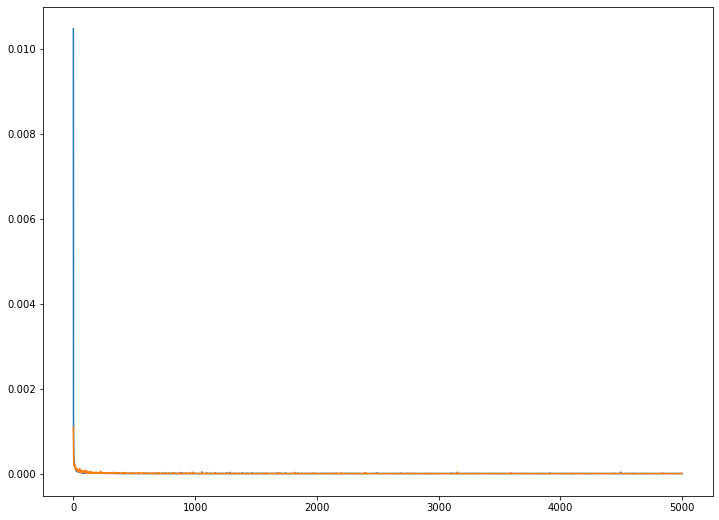

In [14]:
plt.figure(figsize=(12, 9))
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'], label = 'test')

plt.show()

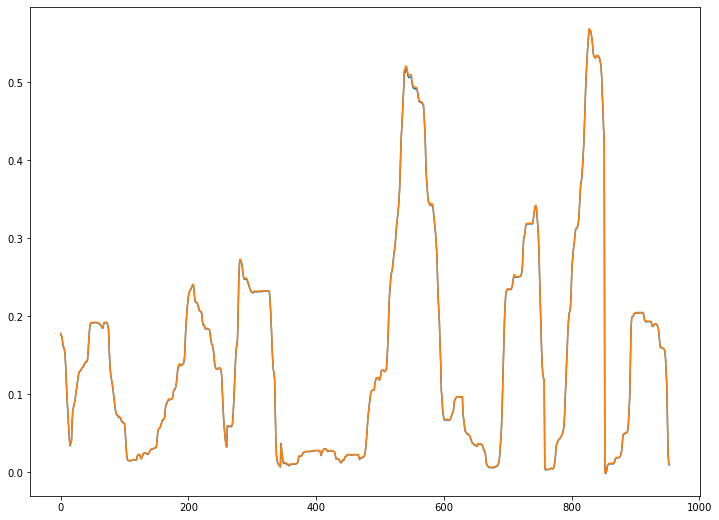

In [15]:
plt.figure(figsize=(12, 9))
plt.plot(pred,label='prediction')
plt.plot(test_y,label='real')
plt.show()